# Семинар 12
# Методы работы в области Small Data AI
# Курс "Компьютерное зрение"

In [ ]:
# Add access to Google Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/ComputerVision/Seminar_12

/content/gdrive/My Drive/ComputerVision/Seminar_12


# 1. Построение Seamese network на основе PyTorch
## 1.1. Что такое Siamese Network?
<figure>
<img src="https://miro.medium.com/max/1313/1*0E9104t29iMBmtvq7G1G6Q.png" width="1000">
</figure> 

A Siamese Neural Network is a class of neural network architectures that contain two or more identical subnetworks. ‘identical’ here means, they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks. It is used to find the similarity of the inputs by comparing its feature vectors, so these networks are used in many applications  
  
Traditionally, a neural network learns to predict multiple classes. This poses a problem when we need to add/remove new classes to the data. In this case, we have to update the neural network and retrain it on the whole dataset. Also, deep neural networks need a large volume of data to train on. SNNs, on the other hand, learn a similarity function. Thus, we can train it to see if the two images are the same (which we will do here). This enables us to classify new classes of data without training the network again.
  
PROS:
- ore Robust to class Imbalance: With the aid of One-shot learning, given a few images per class is sufficient for Siamese Networks to recognize those images in the future
- Nice to an ensemble with the best classifier: Given that its learning mechanism is somewhat different from Classification, simple averaging of it with a Classifier can do much better than average 2 correlated Supervised models (e.g. GBM & RF classifier)
- Learning from Semantic Similarity: Siamese focuses on learning embeddings (in the deeper layer) that place the same classes/concepts close together. Hence, can learn semantic similarity.
   
   
CONS:
- Needs more training time than normal networks: Since Siamese Networks involves quadratic pairs to learn from (to see all information available) it is slower than normal classification type of learning(pointwise learning)
- Doesn’t output probabilities: Since training involves pairwise learning, it won’t output the probabilities of the prediction, but the distance from each class

LOSS FUNCTIONS USED IN SIAMESE NETWORKS
<figure>
<img src="https://miro.medium.com/max/1313/1*kPcSO_9ThH9p8aZHO43myg.png" width="1000">
</figure>   
  
- Triplet loss is a loss function where a baseline (anchor) input is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized. During the training process, an image triplet (anchor image, negative image, positive image)(anchor image, negative image, positive image) is fed into the model as a single sample. The idea behind this is that distance between the anchor and positive images should be smaller than that between the anchor and negative images.
<figure>
<img src="https://miro.medium.com/max/861/1*Wh4VeTKfHR4M4mh-z6fGUA.png" width="1000">
</figure> 

- Contrastive Loss: is a popular loss function used highly nowadays, It is a distance-based loss as opposed to more conventional error-prediction losses. This loss is used to learn embeddings in which two similar points have a low Euclidean distance and two dissimilar points have a large Euclidean distance.
<figure>
<img src="https://miro.medium.com/max/1313/1*Uo5IovRsjW86b-vCBZGRvg.jpeg" width="1000">
</figure> 

## 1.2. Постановка прикладной задачи верификации подписи
<figure>
<img src="https://miro.medium.com/max/875/1*LwOBbwGXMZUy6OzkFAPTzw.png" width="1000">
</figure>  
  
As Siamese networks are mostly used in verification systems such as face recognition, signature verification, etc…, Let’s implement a signature verification system using Siamese neural networks on Pytorch

## 1.3. Подготовка датасета
We are going to use the ICDAR 2011 dataset which consists of the signatures of the dutch users both genuine and fraud, and the dataset itself is separated as train and folders, inside each folder, it consists of users folder separated as genuine and forgery, also the labels of the dataset is available as CSV files

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils


import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
import numpy as np

In [ ]:
training_dir = "Signature/train"
testing_dir = "Signature/test"
training_csv = "Signature/train_data.csv"
testing_csv = "Signature/test_data.csv"

In [ ]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):

        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(training_csv,training_dir,
                                 transform=transforms.Compose([transforms.Resize((105,105)),
                                                               transforms.ToTensor()]))

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, num_workers=2, batch_size=32
)

In [ ]:
# Load the test dataset
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=2, batch_size=1, shuffle=True)

Визуализируем данные

In [ ]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(
            75,
            8,
            text,
            style="italic",
            fontweight="bold",
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 10},
        )
    plt.subplots(figsize=(10,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()

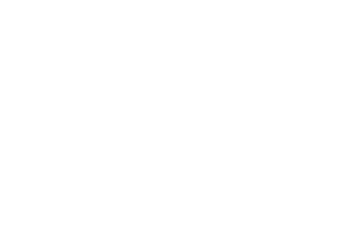

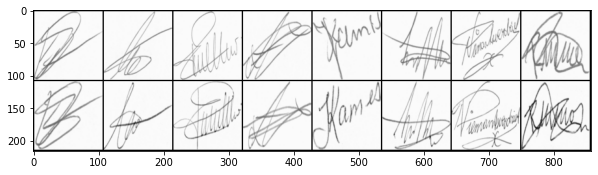

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## 1.4. Создадим нейросетевую модель
Since the weights are constrained to be identical for both networks, we use one model and feed it two images in succession. After that, we calculate the loss value using both the images and then backpropagate. This saves a lot of memory and also computational efficiency.

In [ ]:
# create a siamese network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2),
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## 1.5. Зададим Contrastive loss
For this task, we will use Contrastive Loss, which learns embeddings in which two similar points have a low Euclidean distance and two dissimilar points have a large Euclidean distance, In Pytorch the implementation of Contrastive Loss will be as follows:

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    "Contrastive loss function"

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + (label)
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

## 1.6. Определим функцию для обучения

In [ ]:
# train the model
def train(num_epochs=20):
    loss = []
    counter = []
    iteration_number = 0

    for epoch in range(1, num_epochs):
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()

        print("Epoch {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    show_plot(counter, loss)
    return net

In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)

Epoch 1
 Current loss 0.49044692516326904

Epoch 2
 Current loss 0.8899858593940735

Epoch 3
 Current loss 0.9364219307899475

Epoch 4
 Current loss 1.1081373691558838

Epoch 5
 Current loss 1.1607712507247925

Epoch 6
 Current loss 1.2294518947601318

Epoch 7
 Current loss 1.0892260074615479

Epoch 8
 Current loss 1.2508864402770996

Epoch 9
 Current loss 1.174991250038147

Epoch 10
 Current loss 1.1366688013076782

Epoch 11
 Current loss 1.0331885814666748

Epoch 12
 Current loss 1.16518235206604

Epoch 13
 Current loss 2.1740448474884033

Epoch 14
 Current loss 1.0911771059036255

Epoch 15
 Current loss 1.0285592079162598

Epoch 16
 Current loss 1.4300613403320312

Epoch 17
 Current loss 1.0521867275238037

Epoch 18
 Current loss 0.6031914353370667

Epoch 19
 Current loss 0.4258424937725067

Epoch 20
 Current loss 1.3625155687332153

Epoch 21
 Current loss 0.9568704962730408

Epoch 22
 Current loss 1.3745204210281372

Epoch 23
 Current loss 0.7330154180526733

Epoch 24
 Current loss

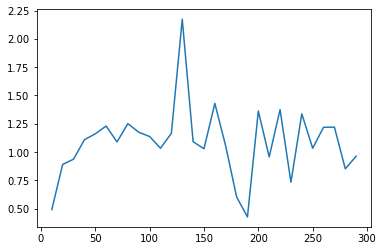

Model Saved Successfully


In [ ]:
# set the device to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train(30)
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

## 1.7. Тестирование модели
Now let’s test our signature verification system on the test dataset:
- Load the test dataset using DataLoader class from Pytorch
- Pass the image pairs and the labels
- Find the euclidean distance between the images
- Based on the euclidean distance print the output

In [ ]:
net.load_state_dict(torch.load('Signature/model.pt'))

<All keys matched successfully>

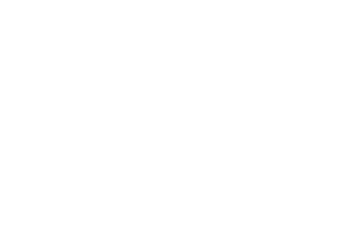

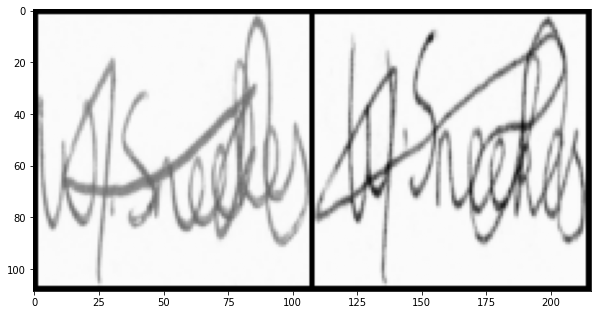

Predicted Eucledian Distance:- 0.9492072463035583
Actual Label:- Forged Pair Of Signature


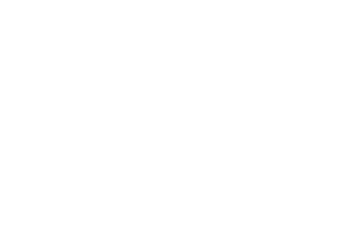

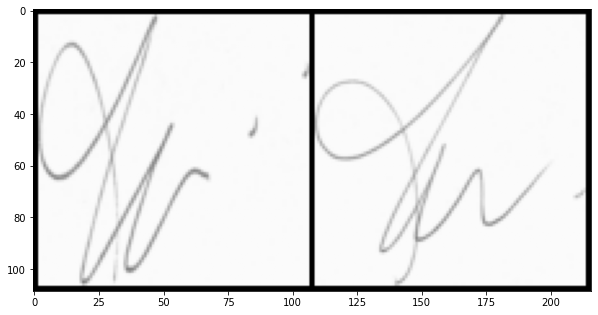

Predicted Eucledian Distance:- 1.3206381797790527
Actual Label:- Original Pair Of Signature


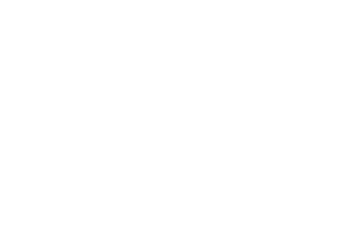

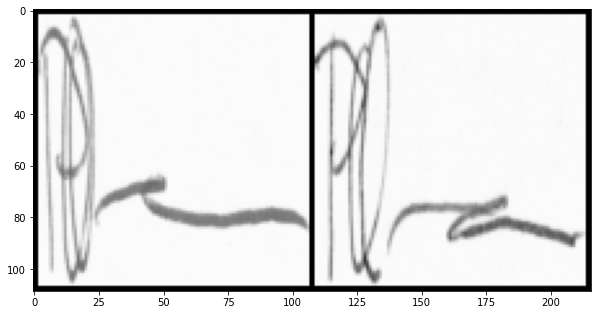

Predicted Eucledian Distance:- 0.7651990652084351
Actual Label:- Forged Pair Of Signature


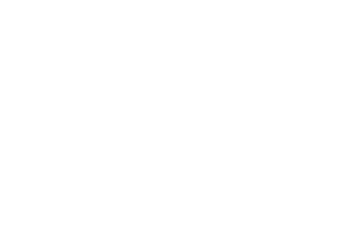

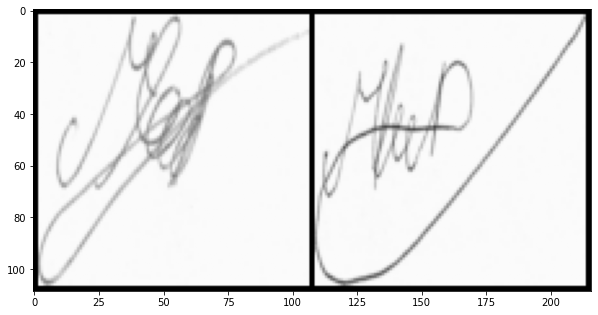

Predicted Eucledian Distance:- 1.1177266836166382
Actual Label:- Forged Pair Of Signature


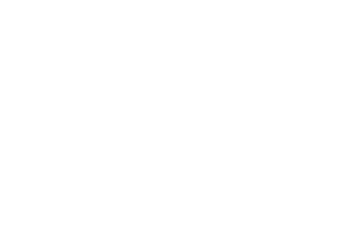

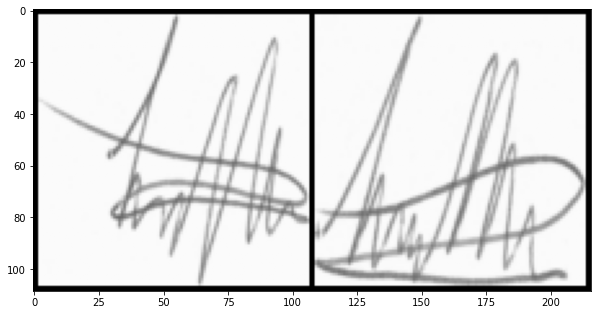

Predicted Eucledian Distance:- 1.0192947387695312
Actual Label:- Original Pair Of Signature


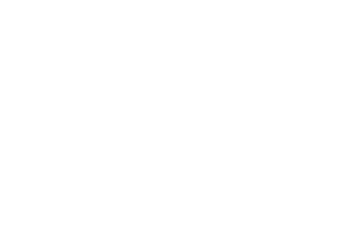

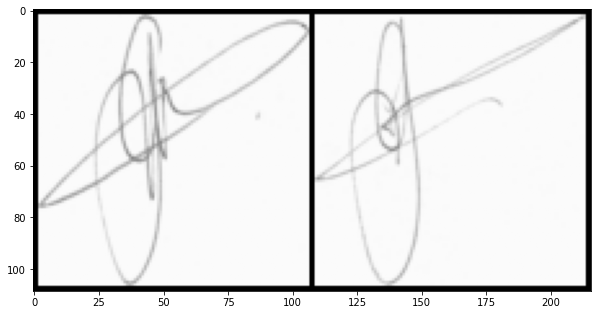

Predicted Eucledian Distance:- 1.7230628728866577
Actual Label:- Original Pair Of Signature


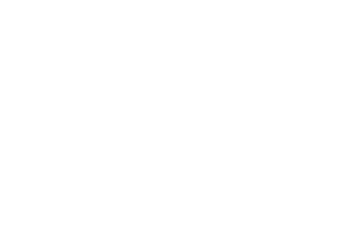

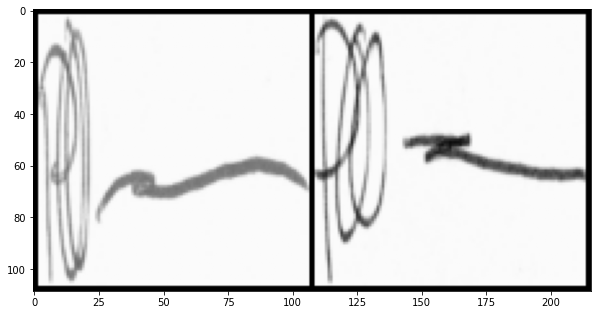

Predicted Eucledian Distance:- 1.7126580476760864
Actual Label:- Forged Pair Of Signature


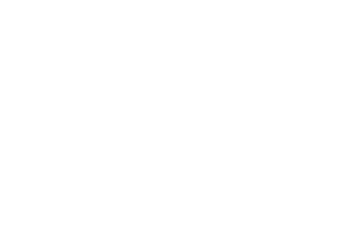

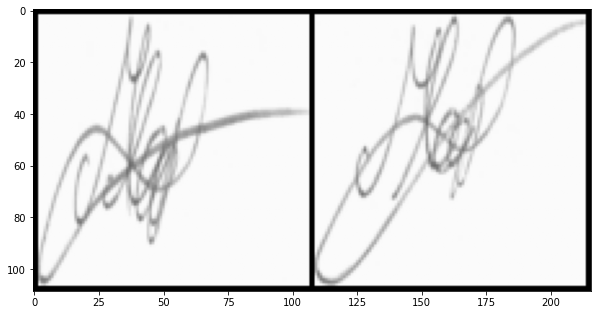

Predicted Eucledian Distance:- 0.868535041809082
Actual Label:- Original Pair Of Signature


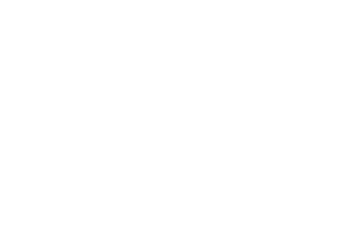

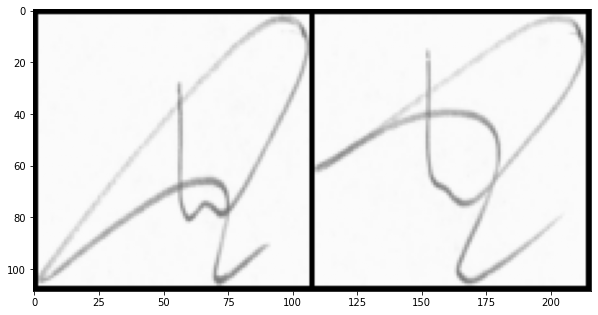

Predicted Eucledian Distance:- 0.9907753467559814
Actual Label:- Original Pair Of Signature


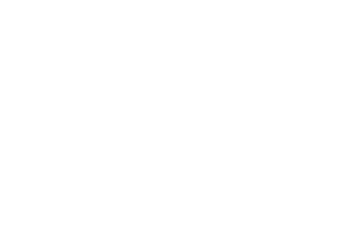

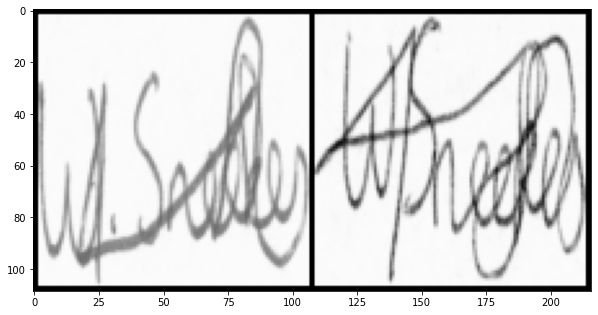

Predicted Eucledian Distance:- 1.208474040031433
Actual Label:- Forged Pair Of Signature


In [ ]:
count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = net(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break

# 2. Triplet loss для Seamese network и реализация на основе TF/Keras
## 2.1. Область применения
> Нужно разработать систему для идентификации сотрудников. Что будет, если мы будем решать задачу распознавания лиц (например) при помощи классификации?


**Подход через классификацию**
* Задача классификации: обучаем нейросеть присваивать вероятность принадлежности объекта к одному из классов
* К сожалению, количество классов заранее определено. В ситуации с распознаванием лиц нам придется добавлять новые классы.

**Проблемы**
* Нам нужно обучить классификатор с *очень* крупным последним слоем: например, $1024 \times n$, где $n$ (в рамках компании среднего размера) может быть $2000-3000$ тысячи
* Увольнение сотрдуника решается довольно "легко" - удаляем часть матрицы. А добавление? Дообучить модель, не *изменяя* веса всех остальных классов, как правило, нельзя. Поэтому приходится обучать заново довольно крупный выходной слой, если не всю модель.
* При этом у вас может не быть большого количества фото новых сотрудников: скорее, 1-2 фото.
* Обучить модель различать двух новых, возможно, похожих людей в таких условиях непросто: выборка по новым классам слишком мала.
* "Дообучить" модель *отдельно* распознавать новых сотрдуников невозможно из-за проблемы *катастрофического забывания*
  
__Идея triplet loss__   

<figure>
<img src="https://omoindrot.github.io/assets/triplet_loss/triplet_loss.png" width="1000">
</figure> 

[Статья FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/abs/1503.03832) - в ней вводится triplet loss.

$L(A, P, N) = max(0, ||f(A) - f(P)||^2 - ||f(A) - f(N)||^2 + \alpha)  $

__Semi-hard negative mining__   

<figure>
<img src="https://omoindrot.github.io/assets/triplet_loss/triplets.png" width="500">
</figure> 

* Простые триплеты - триплеты с лоссом 0, т.к. $d(a,p) + \alpha < d(a,n)$
* Сложные триплеты (hard triplets - : триплеты, в которых отрицательный пример ближе, чем положительный: $d(a,n) < d(a,p)$
* semi-hard triplets - триплеты, в которых отрицательый пример дальше, чем положительный, но все еще в пределах margin $\alpha$: $d(a,p) < d(a,n) < d(a,p)+ \alpha$

Варианты применения триплетов
* Если сеть будет учиться на hard negatives, она может застрять в неудачном локальном минимуме.
* semi-hard negatives помогли избежать этой проблемы.
* В статье [FaceNet](https://arxiv.org/abs/1503.03832) использовали выбор случайного semi-hard примера для каждой пары "якорь-положительное значение".
  
Стратегии подбора примеров
* Оффлайн - стратегия: триплеты примеров генерируются в начале каждой эпохи
* Онлайн: для каждого батча создается $bs^3$ триплетов. Из них отбираются релевантные наборы $(2p, 1n)$. Дальше есть две стратегии:
  * batch all: усредняем лосс от всех (и hard, и semi-hard) примеров. При этом нужно игнорировать easy triplets: те, у которых лосс равен нулю
  * batch hard: для каждого из якорей в батче находим hardest positive и hardest negative.

__Пример взят из открытого урока по компьютерному зрению Otus:__
https://colab.research.google.com/drive/12CumvkPROfbVrx69iGtAD2b1C8jmYy4n?usp=sharing

# 3. Few-shot prototypical network
## 3.1. Подготовим библиотеки

In [ ]:
!pip install easyfsl

     |████████████████████████████████| 61kB 4.7MB/s 


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.data_tools import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## 3.2. Подготовим датасет

In [ ]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py



Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


## 3.3. Повторим идею Few-shot learning и Prototypical Network
Let's take some time to grasp what few-shot classification is. Simply put, in a few-shot classification task, you have a labeled support set (which kind of acts
like a catalog) and query set. For each image of the query set, we want to predict a label from the
labels present in the support set. A few-shot classification model has to use the information from the
support set in order to classify query images. We say *few-shot* when the support set contains very
few images for each label (typically less than 10). The figure below shows a 3-way 2-shots classification task. "3-way" means "3 different classes" and "2-shots" means "2 examples per class".
We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully
predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard,
a Pug or a Labrador can be.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Most few-shot classification methods are *metric-based*. It works in two phases : 1) they use a CNN to project both
support and query images into a feature space, and 2) they classify query images by comparing them to support images.
If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that
it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function that takes an image as input and outputs a representation (or *embedding*) of this image in a given feature space. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.

If you want to learn more about how this works, I explain it
[there](https://www.sicara.ai/blog/2019-07-30-image-classification-few-shot-meta-learning-5fd736a6c54d2).
But now, let's get to coding.
In the code below (modified from [this](https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/methods/prototypical_networks.py)), we simply define Prototypical Networks as a torch module, with a `forward()` method.
You may notice 2 things.

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

## 3.4. Создадим модель

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Now we have a model! Note that we used a pretrained feature extractor, so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model. But a regular PyTorch dataloader will feed batches of images, with no consideration for their label or whether they are support or query. We need 2 specific features in our case.

We need images evenly distributed between a given number of classes.
We need them split between support and query sets.
For the first point, I wrote a custom sampler: it first samples n_way classes from the dataset, then it samples n_shot + n_query images for each class (for a total of n_way * (n_shot + n_query) images in each batch). For the second point, I have a custom collate function to replace the built-in PyTorch collate_fn. This baby feed each batch as the combination of 5 items:

support images
support labels between 0 and n_way
query images
query labels between 0 and n_way
a mapping of each label in range(n_way) to its true class id in the dataset (it's not used by the model but it's very useful for us to know what the true class is)

## 3.5. Предварительно протестируем модель


In [ ]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "labels" field. Check the code if you have any doubt!
test_set.labels = [instance[1] for instance in test_set._flat_character_images]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


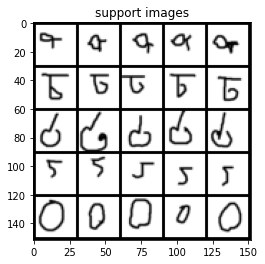

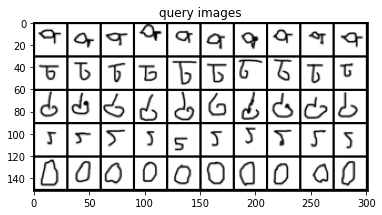

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

For both support and query set, you should have one line for each class.

How does our model perform on this task?

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Mongolian/character14 / Mongolian/character14
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Avesta/character17
Sylheti/character11 / Mongolian/character14
Sylheti/character11 / Sylheti/character11
Sylheti/character11 / Sylheti/character11
Avesta/character17 / Avesta/character17
Avesta/character17 / Mongolian/character14
Avesta/char

This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!

Now that we have a first idea, let's see more precisely how good our model is.

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:08<00:00, 11.20it/s]

Model tested on 100 tasks. Accuracy: 85.54%


With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it a little bit (change the backbone, use other distances than euclidean...) or if you change the problem (more classes in each task, less or more examples in the support set, maybe even one example only, but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to meta-train this model, to get even better results.

## 3.6. Training a meta-learning algorithm
Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set. This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise, but keep in mind that this is not good practice and you should always use validation when training a model for production.

In [ ]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.labels = [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch, feel free to set pretrained=False in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a fit method. This method takes a classification task as input (support set and query set). It predicts the labels of the query set based on the information from the support set; then it compares the predicted labels to ground truth query labels, and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a meta-training loop.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks, and let the fit method update our model after each task. This is called episodic training.

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

In [ ]:
# Or just load mine

!wget https://public-sicara.s3.eu-central-1.amazonaws.com/resnet18_with_pretraining.tar
model.load_state_dict(torch.load("resnet18_with_pretraining.tar", map_location="cuda"))

--2021-04-29 19:06:29--  https://public-sicara.s3.eu-central-1.amazonaws.com/resnet18_with_pretraining.tar
Resolving public-sicara.s3.eu-central-1.amazonaws.com (public-sicara.s3.eu-central-1.amazonaws.com)... 52.219.75.208
Connecting to public-sicara.s3.eu-central-1.amazonaws.com (public-sicara.s3.eu-central-1.amazonaws.com)|52.219.75.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44787039 (43M) [application/x-tar]
Saving to: ‘resnet18_with_pretraining.tar’

resnet18_with_pretr 100%[===================>]  42.71M  12.8MB/s    in 3.3s    

2021-04-29 19:06:33 (12.8 MB/s) - ‘resnet18_with_pretraining.tar’ saved [44787039/44787039]



<All keys matched successfully>

## 3.7. Оценим точность модели

In [ ]:
evaluate(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:08<00:00, 11.96it/s]

Model tested on 100 tasks. Accuracy: 98.26%


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


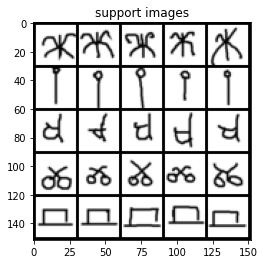

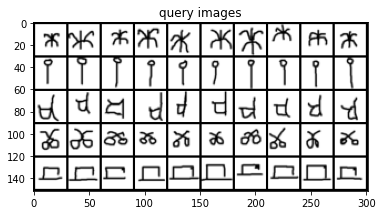

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Old_Church_Slavonic_(Cyrillic)/character07 / Old_Church_Slavonic_(Cyrillic)/character07
Angelic/character19 / Angelic/character19
Angelic/character19 / Angelic/character19
Angelic/cha

It's not surprising that the model performs better after being further trained on Omniglot images than it was with its ImageNet-based parameters. However, we have to keep in mind that the classes on which we just evaluated our model were still not seen during training, so 99% (with a 12% improvement over the model trained on ImageNet) seems like a decent performance.

# 4. Image Anomaly detection на основе автоэнкодера с robust subspace recovery layer
## 4.1. Теоретическое введение

![Anomaly detection](https://www.pyimagesearch.com/wp-content/uploads/2020/03/autoencoder_anomaly_detection_example.jpg)

![Anomaly detection](https://miro.medium.com/max/1916/1*1pjIONX0hIIz4pO9P6-onA.png)

Anomaly detection (or outlier detection) is one of the many tasks that keep Data Scientists awake at night when then need to satisfy the business needs. No matter whether the data in well structured (like user events) or unstructured (like text or images), there are plenty of methods that allow to tackle this problem and it's diffictult to choose one. Sometimes, it's even difficult to properly define, what an anomaly is - but that's not the part of this post main focus. Some of the most popular methods for anomaly detection are:

- statistical methods - like three-sigma rule and regression models
- classical machine learning methods - like one-class SVM, Isolation Forests or clustering-based methods (e.g. kNN)
- deep learning methods - like autoencoders and deep forecasting models (e.g. LSTMs for time series)

### General idea behind Robust Space Recovery Layer
Autoencoders were used for the anomaly detection much earlier than this (RSR) paper appeared. To use autoencoder in a setting of anomaly detection, one treats "normal" examples (inliners) as the ones that have low reconstruction error and other which have high reconstruction error are treated as outliers. Although the idea is fairly easy to understand and implement, the problem lies in the fact that in order for autoencoder to work properly in this setting (i.e. to detect the outliers) the training data should be clean (or have really small fraction of the outliers). In the real world it's highly unlikely for the input data to be free of any anomalies and even if Data Scientists could label and filter the data (given they know what an anomaly in the given dataset is) it simply won't scale.

The *Robust Subspace Recovery Layer* paper tries to adress this issue by incorporating the RSR Layer into autoencoders. It's clearly stated that this method does not compete with semi-supervised or supervised anomaly detection setting, but shows its strenght in the unsupervised setting.

### What is the RSR Layer?
The RSR Layer itself is just an additional layer in the nerual network with specific properties. It maps one representation (embedding obtained from the encoder) into another **low-dimensional representation that is outlier-robust**.

Let's say that *D* (upper case D) is the dimension of the embedding from the encoder. The assumption in the paper is that the "normal" data lies within *d*-dimensional (lower case d) manifold ("subspace") of the original embedding, which means that *d < D*.

Please refeer to the paper to obtain more details and the full explanation and analysis. At this point you should know enough to proceed to the implementation section.

### How to implement the RSR Layer in PyTorch?
As RSR Layer is just a linear mapping, there are only a few things needed:
1. The dimension *D* from the encoder's output.
2. The dimension *d* which is a direct property of the RSR Layer (and probably requires a hyperparamer search to set it properly).
3. Proper initialization of the linear mapping weights (the optimization goal of the RSR Autoencoder enforces that, so it's better to start with a set of weights that already fulfill this constraint).

The implementation of the layer itself is straightforward.

In [ ]:
!pip install pytorch-lightning scikit-learn plotly

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

## 4.2. Реализуем компоненты RSR слоя

In [ ]:
class RSRLayer(nn.Module):
    def __init__(self, d:int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        # z is the output from the encoder
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)

The next piece to obtain RSR Autoencoder in PyTorch is to implement RSR Loss as per paper's equation (4): RSR Loss PyTorch RSRLoss The first term is enforces the RSR Layer projection to be robust and the second term enforces the projection to be orthogonal. Refeer to the paper for the motivation behind this loss as it it out of scope for this blog post.

Nearly op-for-op (math-to-PyTorch) implementation of this loss looks like this:

In [ ]:
class RSRLoss(nn.Module):
    def __init__(self, lambda1, lambda2, d, D):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2

Lastly, the standard L1/L2 reconstruction loss is replaced by the l2,p-norm based loss

In [ ]:
class L2p_Loss(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.p = p
  
    def forward(self, y_hat, y):
        return torch.sum(
            torch.pow(
                torch.norm(y - y_hat, p=2), self.p
            )
        )

## 4.3. Реализуем архитектуру RSR autoencoder

In [ ]:
class RSRAutoEncoder(nn.Module):
    def __init__(self, input_dim, d, D):
        super().__init__()
        # Put your encoder network here, remember about the output D-dimension
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim // 4),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 4, D)
        )

        self.rsr = RSRLayer(d, D)

        # Put your decoder network here, rembember about the input d-dimension
        self.decoder = nn.Sequential(
          nn.Linear(d, D),
          nn.LeakyReLU(),
          nn.Linear(D, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim)
        )
    
    def forward(self, x):
        enc = self.encoder(x) # obtain the embedding from the encoder
        latent = self.rsr(enc) # RSR manifold
        dec = self.decoder(latent) # obtain the representation in the input space
        return enc, dec, latent, self.rsr.A

## 4.4. Подготовим датасет MNIST и его искаженную версию

In [ ]:
import pytorch_lightning as pl

In [ ]:
pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [ ]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

mnist = MNIST(".", download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
class RSRDs(torch.utils.data.Dataset):
    def __init__(self, target_class, other_classes, n_examples_per_other):
        super().__init__()
        self.mnist = MNIST(".", download=True, transform=ToTensor())
        self.target_indices = (self.mnist.targets == target_class).nonzero().flatten()
        
        other = []
        for other_class in other_classes:
            other.extend(
                (self.mnist.targets == other_class).nonzero().flatten()[:n_examples_per_other]
            )
        self.other_indices = torch.tensor(other)
        self.all_indices = torch.cat([self.other_indices, self.target_indices])
        print(f"Targets: {self.target_indices.size(0)}")
        print(f"Others : {self.other_indices.size(0)}")
    
    def __getitem__(self, idx):
        actual_idx = self.all_indices[idx].item()
        return self.mnist[actual_idx]
    
    def __len__(self):
        return self.all_indices.size(0)

In [ ]:
ds = RSRDs(target_class=4, other_classes=(0, 1, 2, 8), n_examples_per_other=100)

Targets: 5842
Others : 400


In [ ]:
ds[0][0].shape, ds[0][1]

(torch.Size([1, 28, 28]), 0)

## 4.5. Соберем RSRAutoencoder
The following module combines all of the pieces together:
1. RSR Autoencoder with RSR Layer inside,
2. L2p reconstruction loss,
3. RSR Loss.

In [ ]:
class RSRAE(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.ae = RSRAutoEncoder(
            self.hparams.input_dim, 
            self.hparams.d, 
            self.hparams.D)
        self.reconstruction_loss = L2p_Loss(p=1.0)
        self.rsr_loss = RSRLoss(self.hparams.lambda1, self.hparams.lambda2, self.hparams.d, self.hparams.D)
  
    def forward(self, x):
        return self.ae(x)
  
    def training_step(self, batch, batch_idx):
        X, _ = batch
        x = X.view(X.size(0), -1)
        enc, dec, latent, A = self.ae(x)

        rec_loss = self.reconstruction_loss(torch.sigmoid(dec), x)
        rsr_loss = self.rsr_loss(enc, A)
        loss = rec_loss + rsr_loss
        
        # log some usefull stuff
        self.log("reconstruction_loss", rec_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        self.log("rsr_loss", rsr_loss.item(), on_step=True, on_epoch=False, prog_bar=True)
        return {"loss": loss}

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        # Fast.AI's best practices :)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=self.hparams.lr, 
                                                        epochs=self.hparams.epochs, 
                                                        steps_per_epoch=self.hparams.steps_per_epoch)
        return [opt], [{
            "scheduler": scheduler,
            "interval": "step"
        }]


In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
hparams = dict(
    d=16,
    D=128,
    input_dim=28*28,
    # Peak learning rate
    lr=0.01,
    # Configuration for the OneCycleLR scheduler
    epochs=150,
    steps_per_epoch=len(dl),
    # lambda coefficients from RSR Loss
    lambda1=1.0,
    lambda2=1.0,
)
model = RSRAE(hparams)
model

RSRAE(
  (ae): RSRAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=392, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=392, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=196, out_features=128, bias=True)
    )
    (rsr): RSRLayer()
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=392, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=392, out_features=784, bias=True)
    )
  )
  (reconstruction_loss): L2p_Loss()
  (rsr_loss): RSRLoss()
)

## 4.6. Обучим модель

In [ ]:
trainer = pl.Trainer(max_epochs=model.hparams.epochs, gpus=1)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, dl)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.core.lightning:
  | Name                | Type           | Params
-------------------------------------------------------
0 | ae                  | RSRAutoEncoder | 772 K 
1 | reconstruction_loss | L2p_Loss       | 0     
2 | rsr_loss            | RSRLoss        | 0     
-------------------------------------------------------
772 K     Trainable params
0         Non-trainable params
772 K     Total params
3.091     Total estimated model params size (MB)


1

## 4.7. Оценим модель
First, let's check the general autoencoder reconstuction.

In [ ]:
model.freeze()
from torchvision.transforms import functional as tvf
from torchvision.utils import make_grid
def reconstruct(x, model):
    enc, x_hat, latent, A = model(x.view(1, -1))
    # x_img = tvf.to_pil_image(
    #     x_hat.squeeze(0).view(1, 28, 28)
    # )
    x_hat = torch.sigmoid(x_hat)
    return tvf.to_pil_image(
      make_grid([x_hat.squeeze(0).view(1, 28, 28), x])
    )

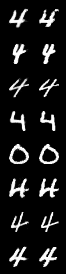

In [ ]:
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in torch.randint(0, len(ds), (8, ))], nrow=1)
)

Most of the images seem OK to me, given how simple the model is. Now let's look at the RSR embedding space projected into 3D using PCA.

In [ ]:
import pandas as pd
rsr_embeddings = []
classes = []
errors = []
for batch in iter(DataLoader(ds, batch_size=64, shuffle=False)):
    X, cl = batch
    x = X.view(X.size(0), -1)
    enc, x_hat, latent, A = model(x)
    rsr_embeddings.append(latent)
    classes.extend(cl.numpy())
    for i in range(X.size(0)):
        rec_error = L2p_Loss()(torch.sigmoid(x_hat[i]).unsqueeze(0), x[i].unsqueeze(0))
        errors.append(float(rec_error.numpy()))
        
all_embs = torch.vstack(rsr_embeddings)
df = pd.DataFrame(all_embs.numpy(), columns=["x", "y", "z"] + [f"dim_{i}" for i in range(hparams["d"] - 3)])
df.loc[:, "class"] = classes
df.loc[:, "errors"] = errors

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rsr_3d = pd.DataFrame(pca.fit_transform(all_embs), columns=["x", "y", "z"])
rsr_3d.loc[:, "class"] = classes

In [ ]:
import plotly.express as px
import plotly
df = df
fig = px.scatter_3d(df, x='x', y='y', z='z',
               symbol="class", color="class", opacity=0.95)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Indeed, most of the 4 (the main class - inliners) reside in the center of the space, with other classes positioned further away from the center.

## 4.8. Применение unsupervised anomaly detection на основе RSR Autoencoder

In [ ]:
df.errors.describe()

count    6242.000000
mean        1.550837
std         0.296197
min         0.328458
25%         1.348866
50%         1.511824
75%         1.706861
max         3.547567
Name: errors, dtype: float64

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
Name: errors, dtype: object

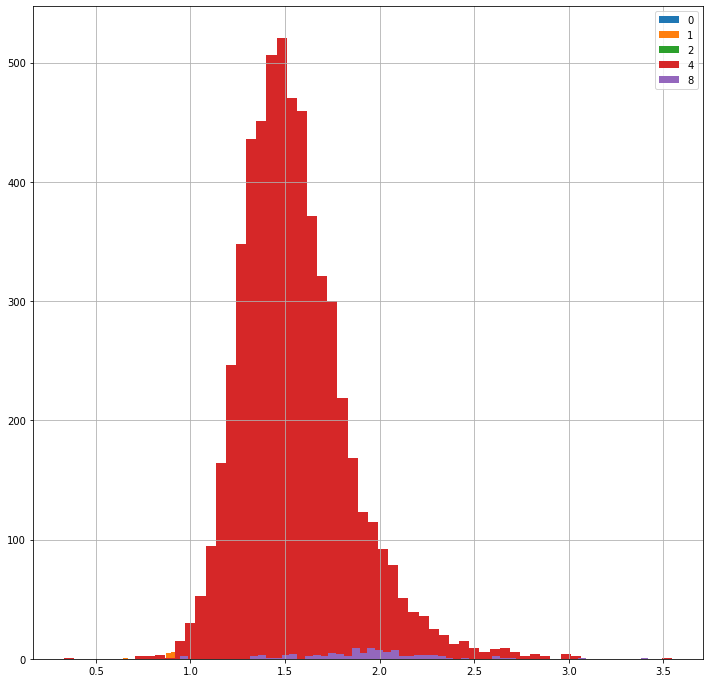

In [ ]:
df.groupby("class").errors.hist(legend=True, bins=60, figsize=(12, 12))

The reconstruction loss is centered around 1.5 with a tail spreading up to 3.46. What are the data points with the largest errors?

In [ ]:
lowest_mistakes = df.sort_values(by="errors", ascending=True).head(60).loc[:, ["errors", "class"]]
highest_mistakes = df.sort_values(by="errors", ascending=False).head(60).loc[:, ["errors", "class"]]
highest_mistakes.head(10)

,errors,class
5917,3.547567,4
369,3.421189,8
305,3.056626,8
1619,3.025076,4
6017,3.021659,4
1312,2.999098,4
983,2.991492,4
634,2.978843,4
4567,2.964016,4
249,2.902241,2


It seems really odd at first, as I've expected all the non-4 classes to have the largest errors. But let's carefully look at the actual results:

Images with the highest reconsturction loss


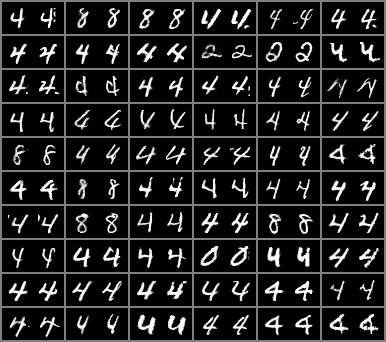

In [ ]:
print("Images with the highest reconsturction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in highest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Images with the lowest reconsturction loss


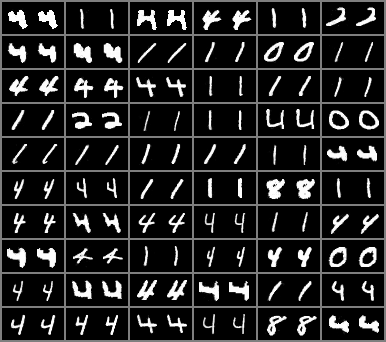

In [ ]:
print("Images with the lowest reconsturction loss")
tvf.to_pil_image(
    make_grid([tvf.to_tensor(reconstruct(ds[i][0], model)) for i in lowest_mistakes.index], nrow=6,
             pad_value=0.5)
)

Now it's much clearer - the model found the manifold that separates the images into the "normal" ones - that in this setting seem like more smooth ones with clean curves - and the outliers that are rather sharp, contain some random artifacts (which are anomalies IMHO) and usually seem slightly malformed. Given the model simplicity and the setup, it looks to me like a good starting point for the unsupervised anomaly detection.

# 5. Unsupervised domain adaptation
## 5.1. Постановка задачи
<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/tl_example.png" width="500">
</figure>  

Let's consider a problem with different domains but an identical task:
- Source domain: MNIST
- Target domain: MNIST-M, a colored and textured version of MNIST  

Task in both cases is the usual 10-class digit classification.

<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/mnist_m.png" width="500">
</figure>  

Unsupervised DA setting: We assume that there are no available labels for the target domain.

We need to force our CNN to learn features of the digis shapes only, not color distributions.

Our approach, (based on Ganin et al. 2015):

- Train a classifier for the domain of an image based on deep convolutonal features.
- Try to maximize the loss of this classifier when training the CNN (confusion loss).
- Simultaneously, minimize the classification loss on the source domain using the same convolutional features.
- Train the digit classifier with source domain data, and the domain classifier with both domains' data.

<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da.png" width="1000">
</figure> 




In [ ]:
# Setup
%matplotlib inline
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.utils.data as data
from PIL import Image

import math
import itertools

import numpy as np
import matplotlib.pyplot as plt

## 5.2. Подготовим датасет

In [ ]:
class MNISTMDataset(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

In [ ]:
import torchvision.transforms as tvtf
import torchvision as tv
image_size = 28
batch_size = 4
data_dir = "data_dir"
tf_source = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,))
])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)

In [ ]:
!ls data_dir

 MNIST	'mnist_m (1)'   mnist_m.tar.gz


In [ ]:
data_dir = "data_dir"
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m (1)', 'mnist_m_train'),
                          os.path.join(data_dir, 'mnist_m (1)', 'mnist_m_train_labels.txt'),
                         transform=tf_target)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

Визуализируем данные

In [ ]:
def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.
    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

In [ ]:
!ls data_dir/'mnist_m (1)'/mnist_m_train

00000000.png  00000026.png  00000052.png  00000078.png	00000104.png
00000001.png  00000027.png  00000053.png  00000079.png	00000105.png
00000002.png  00000028.png  00000054.png  00000080.png	00000106.png
00000003.png  00000029.png  00000055.png  00000081.png	00000107.png
00000004.png  00000030.png  00000056.png  00000082.png	00000108.png
00000005.png  00000031.png  00000057.png  00000083.png	00000109.png
00000006.png  00000032.png  00000058.png  00000084.png	00000110.png
00000007.png  00000033.png  00000059.png  00000085.png	00000111.png
00000008.png  00000034.png  00000060.png  00000086.png	00000112.png
00000009.png  00000035.png  00000061.png  00000087.png	00000113.png
00000010.png  00000036.png  00000062.png  00000088.png	00000114.png
00000011.png  00000037.png  00000063.png  00000089.png	00000115.png
00000012.png  00000038.png  00000064.png  00000090.png	00000116.png
00000013.png  00000039.png  00000065.png  00000091.png	00000117.png
00000014.png  00000040.png  00000066.png  000000

FileNotFoundError: ignored

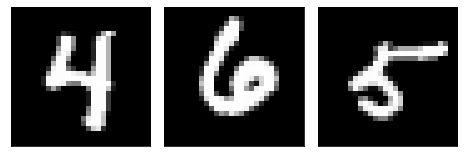

In [ ]:
dataset_first_n(ds_source, 3, cmap='gray');
dataset_first_n(ds_target, 3);

## 5.3. Построим модель
Our model will consist of three parts, as in the figure:

- A "deep" CNN for image feature extraction (2x Conv, ReLU, MaxPool)
- A digit-classification head (3x FC, ReLU)
- A domain classification head (2x FC, ReLU), with gradient reversal layer (GRL).

<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da2.png" width="1000">
</figure> 

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [ ]:
import torch.nn as nn

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.Conv2d(64, 50, kernel_size=5),
            nn.BatchNorm2d(50), nn.Dropout2d(), nn.MaxPool2d(2),
            nn.ReLU(True),
        )
        self.class_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100), nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(100, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(50 * 4 * 4, 100), nn.BatchNorm1d(100),
            nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, 50 * 4 * 4)
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        class_pred = self.class_classifier(features)
        domain_pred = self.domain_classifier(reverse_features)

Wait, but why let λ (grl_lambda in the code) change during training (e.g. every epoch)?

- In the beginning of training, the domain loss is extremely noisy since the CNN features are not good yet.
- Therefore, lambda is gradulaly changed from 0 to 1 in the course of training.

$$ \lambda_p = \frac{2}{1+\exp(-10\cdot p)} -1, $$
where p∈[0,1] is the training progress.

In [ ]:
model = DACNN()

x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s)
model(x0_t)

source domain:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain:  torch.Size([4, 3, 28, 28]) torch.Size([4])


## 5.4. Обучение модели


In [ ]:
import torch.optim as optim
lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [ ]:
batch_size = 1024
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [ ]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
              f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
              f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
             )
        if batch_idx == 2:
            print('This is just a demo, stopping...')
            break

Epoch 0001 / 0001


TypeError: ignored

## 5.5. Визуализация embedding'ов
It's useful to visualize the space of the convolutional features learned by the model.

Recall, our domain confusion loss was supposed to make images from both domains look the same for the classifier.

<figure>
<img src="https://nbviewer.jupyter.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/img/ganin_da3.png" width="1000">
</figure> 

# 6. Использованные материалы
- https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942
- https://www.sicara.ai/blog/your-few-shot-model-15mn-pytorch

